In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tea-leaf-health-dataset/Tea leaf Dataset/Diseased Leaf/IMG20230816192835.jpg
/kaggle/input/tea-leaf-health-dataset/Tea leaf Dataset/Healthy Leaf/IMG20230816190644.jpg


# =========================
# Task 1: EDA + Aug Probe
# =========================

In [2]:
import os, glob, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter

import cv2

In [3]:
DATA_DIR = "/kaggle/input/tea-leaf-health-dataset/Tea leaf Dataset"  # change if needed
CLASSES = ["Healthy Leaf", "Diseased Leaf"]

                                            filepath  label         class
0  /kaggle/input/tea-leaf-health-dataset/Tea leaf...      0  Healthy Leaf
1  /kaggle/input/tea-leaf-health-dataset/Tea leaf...      0  Healthy Leaf
2  /kaggle/input/tea-leaf-health-dataset/Tea leaf...      0  Healthy Leaf
3  /kaggle/input/tea-leaf-health-dataset/Tea leaf...      0  Healthy Leaf
4  /kaggle/input/tea-leaf-health-dataset/Tea leaf...      0  Healthy Leaf

Total images: 747

Class distribution:
 class
Diseased Leaf    395
Healthy Leaf     352
Name: count, dtype: int64


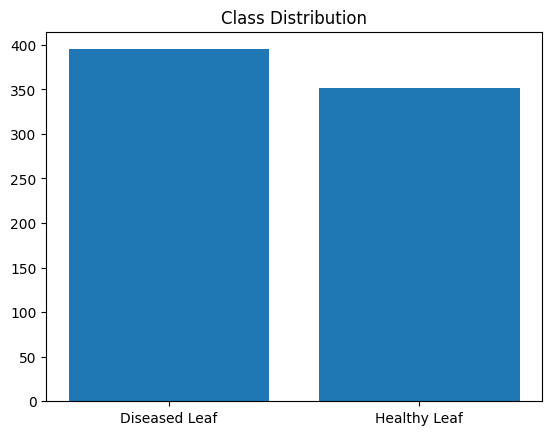

In [4]:
filepaths, labels = [], []
for i, cls in enumerate(CLASSES):
    paths = glob.glob(os.path.join(DATA_DIR, cls, "*"))
    paths = [p for p in paths if p.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]
    filepaths.extend(paths)
    labels.extend([i]*len(paths))

df = pd.DataFrame({"filepath": filepaths, "label": labels})
df["class"] = df["label"].map({0: CLASSES[0], 1: CLASSES[1]})

print(df.head())
print("\nTotal images:", len(df))

# --------- Class balance ----------
counts = df["class"].value_counts()
print("\nClass distribution:\n", counts)

plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

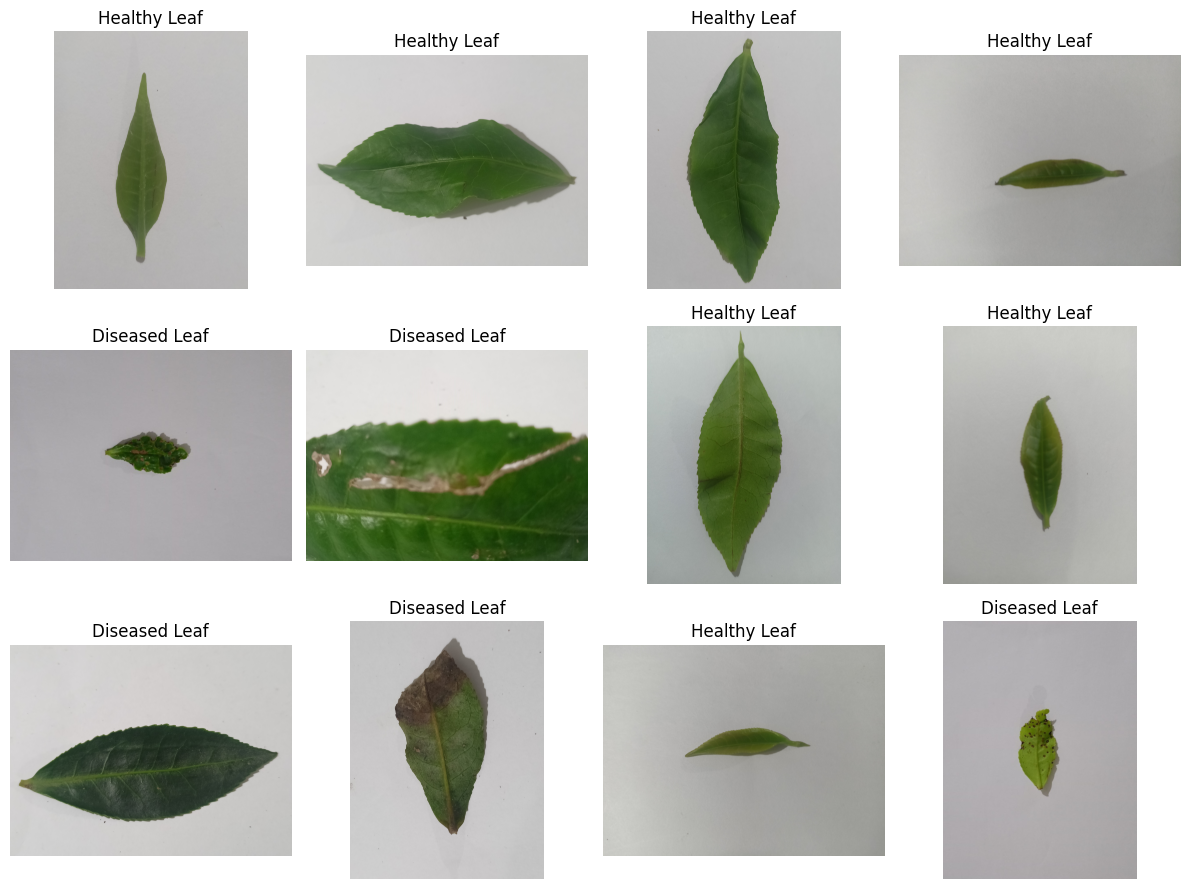

In [5]:
def show_samples(df, n=8):
    sample = df.sample(n=min(n, len(df)), random_state=42)
    cols = 4
    rows = int(np.ceil(len(sample)/cols))
    plt.figure(figsize=(12, 3*rows))
    for idx, (_, r) in enumerate(sample.iterrows()):
        img = Image.open(r["filepath"]).convert("RGB")
        plt.subplot(rows, cols, idx+1)
        plt.imshow(img)
        plt.title(r["class"])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(df, n=12)


             width     height  aspect_ratio
count   500.000000   500.0000    500.000000
mean   3982.834000  3783.2420      1.097666
std     960.915688   969.8504      0.286516
min     960.000000   960.0000      0.750000
25%    3468.000000  3468.0000      0.750000
50%    4624.000000  3468.0000      1.333333
75%    4624.000000  4624.0000      1.333333
max    9248.000000  9248.0000      1.333333


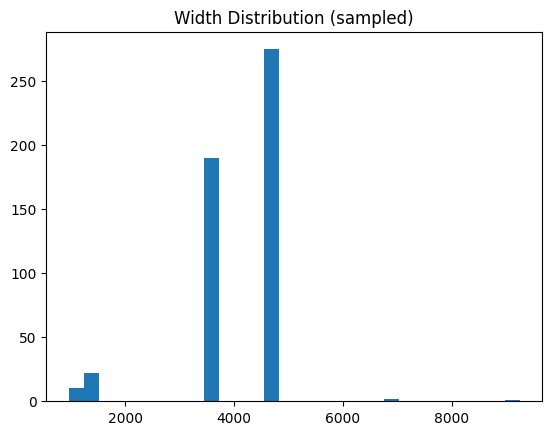

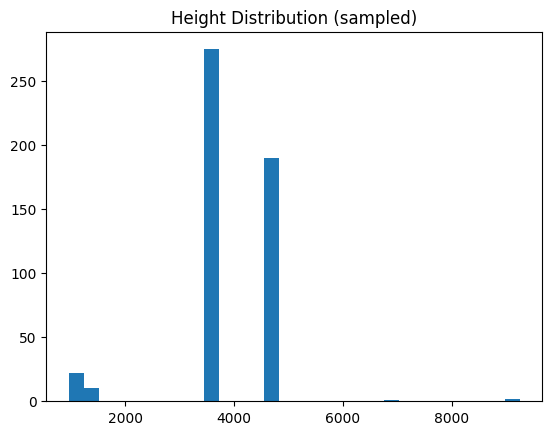

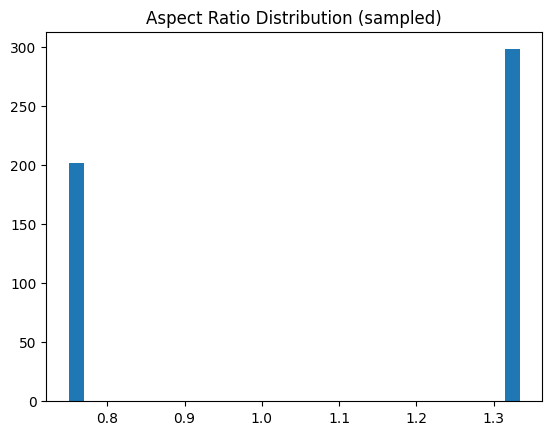

In [6]:
def get_img_info(path):
    img = Image.open(path)
    w, h = img.size
    return w, h, w/h

ws, hs, ars = [], [], []
for p in df["filepath"].sample(min(500, len(df)), random_state=7):  # sample for speed
    w, h, ar = get_img_info(p)
    ws.append(w); hs.append(h); ars.append(ar)

info_df = pd.DataFrame({"width": ws, "height": hs, "aspect_ratio": ars})
print(info_df.describe())

plt.figure()
plt.hist(info_df["width"], bins=30)
plt.title("Width Distribution (sampled)")
plt.show()

plt.figure()
plt.hist(info_df["height"], bins=30)
plt.title("Height Distribution (sampled)")
plt.show()

plt.figure()
plt.hist(info_df["aspect_ratio"], bins=30)
plt.title("Aspect Ratio Distribution (sampled)")
plt.show()

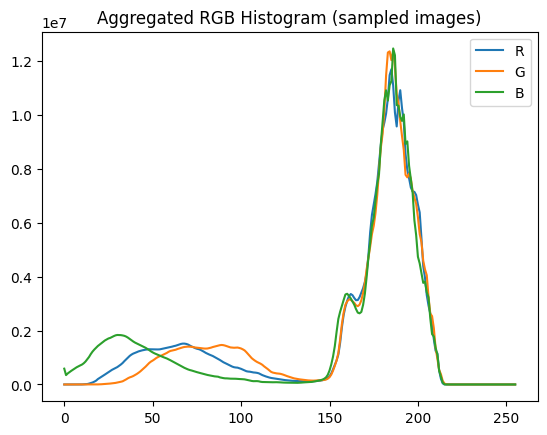

In [7]:
def rgb_hist(img_np):
    # img_np uint8 RGB
    hists = []
    for c in range(3):
        hist, _ = np.histogram(img_np[:,:,c].ravel(), bins=256, range=(0,255))
        hists.append(hist)
    return hists

sample_paths = df["filepath"].sample(min(30, len(df)), random_state=13).tolist()
acc_hist = [np.zeros(256), np.zeros(256), np.zeros(256)]

for p in sample_paths:
    img = np.array(Image.open(p).convert("RGB"))
    hists = rgb_hist(img)
    for c in range(3):
        acc_hist[c] += hists[c]

plt.figure()
plt.plot(acc_hist[0], label="R")
plt.plot(acc_hist[1], label="G")
plt.plot(acc_hist[2], label="B")
plt.title("Aggregated RGB Histogram (sampled images)")
plt.legend()
plt.show()

# ===========================================================================================
# Task 2: Pre-trained Baselines (ResNet, VGG, EfficientNet) + Metrics + K-fold + Paired t-test
# ============================================================================================

In [8]:
import os, time
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from scipy.stats import ttest_rel

from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10            
LR = 1e-4
N_SPLITS = 5


2026-02-14 20:10:26.163685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771099826.334972      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771099826.385244      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771099826.806253      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771099826.806283      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771099826.806286      24 computation_placer.cc:177] computation placer alr

In [9]:
X = df["filepath"].values
y = df["label"].values


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, tf.cast(label, tf.int32)

train_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True) if training else ds
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (train_aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


I0000 00:00:1771099839.802192      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
def build_model(backbone_name):
    if backbone_name == "ResNet50":
        base = tf.keras.applications.ResNet50(
            include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        preprocess = tf.keras.applications.resnet.preprocess_input
    elif backbone_name == "VGG16":
        base = tf.keras.applications.VGG16(
            include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        preprocess = tf.keras.applications.vgg16.preprocess_input
    elif backbone_name == "EfficientNetB0":
        base = tf.keras.applications.EfficientNetB0(
            include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        preprocess = tf.keras.applications.efficientnet.preprocess_input
    else:
        raise ValueError("Unknown backbone")

    base.trainable = False  # transfer learning (freeze initial layers)

    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess(inp)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

def eval_metrics(y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # per-class accuracy: diag / row-sum
    per_class_acc = (cm.diagonal() / cm.sum(axis=1)).tolist() if cm.sum() > 0 else [0, 0]

    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = np.nan

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "cm": cm,
        "per_class_acc": per_class_acc
    }

backbones = ["ResNet50", "VGG16", "EfficientNetB0"]

all_results = []
fold_acc = {b: [] for b in backbones}

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    train_ds = make_ds(X_train, y_train, training=True)
    test_ds  = make_ds(X_test, y_test, training=False)

    for backbone in backbones:
        print(f"\n--- Training {backbone} ---")
        model = build_model(backbone)

        t0 = time.time()
        history = model.fit(
            train_ds,
            epochs=EPOCHS,
            validation_data=test_ds,
            verbose=1,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )
        train_time = time.time() - t0

        # Inference time
        t1 = time.time()
        y_prob = model.predict(test_ds, verbose=0).ravel()
        infer_time = time.time() - t1

        metrics = eval_metrics(y_test, y_prob)
        fold_acc[backbone].append(metrics["accuracy"])

        all_results.append({
            "fold": fold,
            "model": backbone,
            "accuracy": metrics["accuracy"],
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"],
            "auc": metrics["auc"],
            "healthy_acc": metrics["per_class_acc"][0],
            "diseased_acc": metrics["per_class_acc"][1],
            "train_time_sec": train_time,
            "infer_time_sec": infer_time,
        })

        print("Confusion Matrix:\n", metrics["cm"])
        print(f"Acc={metrics['accuracy']:.4f}, P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")
        print(f"Per-class acc (Healthy, Diseased) = {metrics['per_class_acc']}")

results_df = pd.DataFrame(all_results)
print("\n===== Summary (mean across folds) =====")
summary = results_df.groupby("model")[["accuracy","precision","recall","f1","auc","train_time_sec","infer_time_sec","healthy_acc","diseased_acc"]].mean().sort_values("accuracy", ascending=False)
display(summary)


========== Fold 1/5 ==========

--- Training ResNet50 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1771099854.523236      68 service.cc:152] XLA service 0x7f63e0003410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771099854.523288      68 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771099860.529209      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4618 - loss: 0.7441

I0000 00:00:1771099866.650415      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.4801 - loss: 0.7304 - val_accuracy: 0.5200 - val_loss: 0.6954
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5038 - loss: 0.7173 - val_accuracy: 0.5267 - val_loss: 0.6945
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.4973 - loss: 0.7136 - val_accuracy: 0.5267 - val_loss: 0.6937
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.5311 - loss: 0.7142 - val_accuracy: 0.5267 - val_loss: 0.6930
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5127 - loss: 0.6994 - val_accuracy: 0.5267 - val_loss: 0.6925
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.4969 - loss: 0.7187 - val_accuracy: 0.5267 - val_loss: 0.6914
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5081 - loss: 0.7099 - val_accuracy: 0.5267 - val_loss: 0.6906
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.4938 - loss: 0.7260 - val_accuracy: 0.5267 - val_loss: 0.6899
Epo

,accuracy,precision,recall,f1,auc,train_time_sec,infer_time_sec,healthy_acc,diseased_acc
model,,,,,,,,,
EfficientNetB0,0.528787,0.528787,1.0,0.691772,0.334523,499.729429,24.016862,0.0,1.0
ResNet50,0.516707,0.422747,0.8,0.553176,0.621712,714.770322,19.229227,0.2,0.8
VGG16,0.495374,0.212081,0.4,0.277193,0.304153,695.558316,13.951290,0.6,0.4


In [12]:
print("\n===== Paired t-test (Accuracy) =====")
pairs = [("ResNet50","VGG16"), ("ResNet50","EfficientNetB0"), ("VGG16","EfficientNetB0")]
for a, b in pairs:
    t_stat, p_val = ttest_rel(fold_acc[a], fold_acc[b])
    print(f"{a} vs {b}: t={t_stat:.4f}, p={p_val:.6f} | acc_A={np.mean(fold_acc[a]):.4f}, acc_B={np.mean(fold_acc[b]):.4f}")

# ---- Optional: ROC Curve for the best model on last fold (example) ----
best_model = summary.index[0]
print("\nBest model by mean accuracy:", best_model)


===== Paired t-test (Accuracy) =====
ResNet50 vs VGG16: t=1.6330, p=0.177808 | acc_A=0.5167, acc_B=0.4954
ResNet50 vs EfficientNetB0: t=-1.0000, p=0.373901 | acc_A=0.5167, acc_B=0.5288
VGG16 vs EfficientNetB0: t=-2.4386, p=0.071316 | acc_A=0.4954, acc_B=0.5288

Best model by mean accuracy: EfficientNetB0
